<a href="https://colab.research.google.com/github/Es101-am/TL-DPO/blob/main/DPO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Wed May 21 08:26:29 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             43W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [7]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

# Set model ID from Hugging Face Hub
model_id = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

# Load tokenizer and model directly from Hugging Face
tokenizer = AutoTokenizer.from_pretrained(model_id)

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",               # Automatically chooses device (use "cpu" if needed)
    torch_dtype=torch.float32        # Required for CPU
)


In [8]:
import torch

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# List of prompts
prompts = [
   "Can you guide me through the steps to create a personal monthly budget?"

]

# Move model to the device once
model.to(device)

# Generate responses
for prompt in prompts:
    print(f"\nPrompt: {prompt}\n{'-'*40}")

    # Tokenize the prompt and move to device
    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    # Generate response
    with torch.no_grad():
        output_ids = model.generate(
            **inputs,
            max_new_tokens=100,
            do_sample=True,
            top_k=50,
            top_p=0.95,
            temperature=0.8,
            pad_token_id=tokenizer.eos_token_id
        )

    # Decode and print the generated text
    response = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    print("Model response:\n", response)


Using device: cuda

Prompt: Can you guide me through the steps to create a personal monthly budget?
----------------------------------------
Model response:
 Can you guide me through the steps to create a personal monthly budget?


In [9]:
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model

# Enable gradient checkpointing
model.gradient_checkpointing_enable()

In [10]:
def summarize_trainable_params(model):
    """
    Display a breakdown of trainable vs. non-trainable parameters in the model.
    """
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen_params = total_params - trainable_params

    print(f"Total Parameters: {total_params}")
    print(f"Trainable Parameters: {trainable_params}")
    print(f"Frozen Parameters: {frozen_params}\n")

    print("Trainable parameter names:")
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"  - {name}")

    print("\nFrozen parameter names:")
    for name, param in model.named_parameters():
        if not param.requires_grad:
            print(f"  - {name}")


In [11]:
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 2048)
    (layers): ModuleList(
      (0-21): 22 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=5632, bias=False)
          (up_proj): Linear(in_features=2048, out_features=5632, bias=False)
          (down_proj): Linear(in_features=5632, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((2048,), eps=1e-05)
    (rotary_emb): 

In [12]:
from peft import LoraConfig

# Define LoRA settings for adaptation in a causal language modeling task
lora_settings = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=[
        "self_attn.q_proj",
        "self_attn.k_proj",
        "self_attn.v_proj",
        "self_attn.o_proj",
        "mlp.gate_proj",
        "mlp.up_proj",
        "mlp.down_proj",
    ],
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM"
)


In [13]:
from peft import get_peft_model

# Apply the LoRA configuration to transform the base model into a PEFT-compatible model
model = get_peft_model(model, peft_config=lora_settings)

# Optional: review which layers are trainable after adaptation
# summarize_trainable_params(model)


In [14]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)
print(tokenizer)
print(tokenizer.vocab_size)

LlamaTokenizerFast(name_or_path='TinyLlama/TinyLlama-1.1B-Chat-v1.0', vocab_size=32000, model_max_length=2048, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '</s>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)
32000


In [15]:
# Ensure the tokenizer includes a padding token
if "<pad>" not in tokenizer.vocab:
    num_tokens_added = tokenizer.add_special_tokens({"pad_token": "<pad>"})
else:
    num_tokens_added = 0

# Resize the model's embedding layer if the tokenizer vocabulary was extended
if num_tokens_added:
    model.resize_token_embeddings(len(tokenizer))
    print("\n🔧 Adjusted model embeddings to accommodate new tokenizer tokens\n")

# Set the padding token ID in the model configuration
model.config.pad_token_id = tokenizer.pad_token_id

# Validate that the pad token is correctly assigned
assert model.config.pad_token_id == tokenizer.pad_token_id, "Mismatch in pad token IDs!"

# Display padding token info for verification
print(f"Pad Token ID → Tokenizer: {tokenizer.pad_token_id}, Model: {model.config.pad_token_id}")

# Confirm the end-of-sequence token alignment
assert model.config.eos_token_id == tokenizer.eos_token_id, "EOS token ID mismatch between model and tokenizer."

# Align the tokenizer's max length with the model's context window
tokenizer.model_max_length = model.config.max_position_embeddings

# Display additional token information
print(f"EOS Token ID → {tokenizer.eos_token_id} | Decoded: {tokenizer.decode([tokenizer.eos_token_id])}")
print(f"BOS Token ID → {model.config.bos_token_id} | Decoded: {tokenizer.decode([model.config.bos_token_id])}")

# Optionally inspect the full tokenizer object
print("Tokenizer overview:", tokenizer)

# Alternative padding handling strategy if needed:
# tokenizer.pad_token = tokenizer.unk_token
# tokenizer.pad_token_id = tokenizer.unk_token_id
# tokenizer.padding_side = "left"


The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
The new lm_head weights will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`



🔧 Adjusted model embeddings to accommodate new tokenizer tokens

Pad Token ID → Tokenizer: 32000, Model: 32000
EOS Token ID → 2 | Decoded: </s>
BOS Token ID → 1 | Decoded: <s>
Tokenizer overview: LlamaTokenizerFast(name_or_path='TinyLlama/TinyLlama-1.1B-Chat-v1.0', vocab_size=32000, model_max_length=2048, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	32000: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)


In [16]:
print("Special tokens map:", tokenizer.special_tokens_map)

# Optionally, print all special tokens (commented out in your image)
# print("All special tokens:", tokenizer.all_special_tokens)

Special tokens map: {'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>'}


In [17]:
import torch
from transformers import TextStreamer
from peft import PeftModel
import gc  # Garbage collection to free unused memory

def run_streaming_inference(user_input, model_variant, adapter_path=""):
    # Choose which model to use for inference
    if model_variant == "base":
        active_model = model
    elif model_variant == "fine-tuned":
        active_model = PeftModel.from_pretrained(model, adapter_path).to("cuda")

        # Check for any parameters still on CPU (debugging)
        for name, param in active_model.named_parameters():
            if param.device.type == "cpu":
                print(f"⚠️ Parameter still on CPU: {name}")
    else:
        raise ValueError("model_variant must be 'base' or 'fine-tuned'")

    # Set caching behavior
    active_model.config.use_cache = True

    # Format prompt using LLaMA-style instruction tags
    instr_start, instr_end = "[INST]", "[/INST]"
    structured_prompt = f"{instr_start} {user_input.strip()} {instr_end}"
    print(f"Formatted prompt:\n{structured_prompt}")

    # Tokenize and move input to GPU
    encoded_input = tokenizer([structured_prompt], return_tensors="pt").to("cuda")

    # Remove token_type_ids if not supported
    encoded_input.pop("token_type_ids", None)

    # Create a streaming output handler
    output_streamer = TextStreamer(tokenizer)

    # Device confirmation logs
    print(f"Model running on: {next(active_model.parameters()).device}")
    print(f"Input device: {encoded_input['input_ids'].device}")

    # Run generation with streaming enabled
    _ = active_model.generate(
        **encoded_input,
        streamer=output_streamer,
        max_new_tokens=50,
        pad_token_id=tokenizer.pad_token_id
    )

    # Memory cleanup after generation
    if torch.cuda.is_available():
        print("Releasing GPU memory...")
        torch.cuda.empty_cache()
    else:
        print("Running CPU memory cleanup...")
    gc.collect()


In [18]:
def evaluation(model_type, checkpoint=''):
    questions = [
        "Can you guide me through the steps to create a personal monthly budget?",
    ]

    # Optionally provide some correct answers for comparison. This is for manual eval.
    answers = [
        "To create a personal monthly budget, pay yourself first, track and limit spending, save for emergencies, plan for retirement early, and seek financial advice when needed.",
    ]

    for question, answer in zip(questions, answers):
        run_streaming_inference(question, model_type, checkpoint)
        # print("Correct Answer:", answer)
        print('\n\n')

In [19]:
print(model.generation_config)

GenerationConfig {
  "bos_token_id": 1,
  "eos_token_id": 2,
  "max_length": 2048,
  "pad_token_id": 0
}



In [20]:
evaluation("base")

Formatted prompt:
[INST] Can you guide me through the steps to create a personal monthly budget? [/INST]
Model running on: cuda:0
Input device: cuda:0
<s> [INST] Can you guide me through the steps to create a personal monthly budget? [/INST]

Step 1: Determine your income and expenses

1. Determine your monthly income by subtracting your monthly expenses from your monthly income.

2. Calculate your monthly expenses
Releasing GPU memory...





In [9]:
!wget https://huggingface.co/datasets/OpenAssistant/oasst1/resolve/main/2023-04-12_oasst_ready.trees.jsonl.gz


--2025-05-21 11:12:34--  https://huggingface.co/datasets/OpenAssistant/oasst1/resolve/main/2023-04-12_oasst_ready.trees.jsonl.gz
Resolving huggingface.co (huggingface.co)... 108.138.246.79, 108.138.246.71, 108.138.246.85, ...
Connecting to huggingface.co (huggingface.co)|108.138.246.79|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.hf.co/repos/1f/ee/1fee66b6fc467613ff62f20bb7139c905acb4df617d807af37290112c3b672e5/2a9a8fd343e9b28e04a895a669d3253f82d93e9c174d440199ae19d5fafbdff7?response-content-disposition=inline%3B+filename*%3DUTF-8%27%272023-04-12_oasst_ready.trees.jsonl.gz%3B+filename%3D%222023-04-12_oasst_ready.trees.jsonl.gz%22%3B&response-content-type=application%2Fgzip&Expires=1747829554&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0NzgyOTU1NH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9yZXBvcy8xZi9lZS8xZmVlNjZiNmZjNDY3NjEzZmY2MmYyMGJiNzEzOWM5MDVhY2I0ZGY2MTdkODA3YWYzNzI5MDExMmMzYjY3Mm

In [21]:
import pandas as pd

# Load the JSONL file using pandas to avoid schema conflicts
df = pd.read_json("2023-04-12_oasst_ready.trees.jsonl.gz", lines=True)


In [28]:
from datasets import Dataset

# Keep only the first 5,000 rows
df_subset = df.head(5000).reset_index(drop=True)

# Convert to Hugging Face Dataset
data = Dataset.from_pandas(df_subset)



In [29]:
row = data[0]  # first conversation tree
root_prompt = row.get("prompt", {}).get("text")

# Collect assistant replies
assistant_replies = [
    reply for reply in row.get("prompt", {}).get("replies", [])
    if reply.get("role") == "assistant" and reply.get("rank") is not None
]

# Sort by rank (0 = best, higher = worse)
assistant_replies = sorted(assistant_replies, key=lambda r: r["rank"])

# Extract chosen and rejected if available
chosen = assistant_replies[0]["text"] if len(assistant_replies) > 0 else None
rejected = assistant_replies[1]["text"] if len(assistant_replies) > 1 else None

# Display results
print("Prompt:\n", root_prompt)
print("\nChosen Response (rank 0):\n", chosen)
print("\nRejected Response (rank 1 or more):\n", rejected)


Prompt:
 Can you write a short introduction about the relevance of the term "monopsony" in economics? Please use examples related to potential monopsonies in the labour market and cite relevant research.

Chosen Response (rank 0):
 "Monopsony" refers to a market structure where there is only one buyer for a particular good or service. In economics, this term is particularly relevant in the labor market, where a monopsony employer has significant power over the wages and working conditions of their employees. The presence of a monopsony can result in lower wages and reduced employment opportunities for workers, as the employer has little incentive to increase wages or provide better working conditions.

Recent research has identified potential monopsonies in industries such as retail and fast food, where a few large companies control a significant portion of the market (Bivens & Mishel, 2013). In these industries, workers often face low wages, limited benefits, and reduced bargaining po

In [30]:
# Extract prompt text from the first row
text = data[0]["prompt"]["text"]

# Tokenize the text
tokens = tokenizer.encode(text, add_special_tokens=True)

# Decode back to text
decoded_text = tokenizer.decode(tokens)

# Print tokens and decoded text
print("Token IDs:", tokens)
print("Decoded Text:", decoded_text)


Token IDs: [1, 1815, 366, 2436, 263, 3273, 18707, 1048, 278, 29527, 749, 310, 278, 1840, 376, 3712, 459, 1100, 29891, 29908, 297, 7766, 1199, 29973, 3529, 671, 6455, 4475, 304, 7037, 1601, 459, 1100, 583, 297, 278, 23390, 9999, 322, 274, 568, 8018, 5925, 29889]
Decoded Text: <s> Can you write a short introduction about the relevance of the term "monopsony" in economics? Please use examples related to potential monopsonies in the labour market and cite relevant research.


In [38]:
model_name = model_id.split("/")[-1]
dataset_name = "2023-04-12_oasst_ready.trees"

context_length = 512
grad_accum = 16
batch_size = 1
fine_tune_tag = 'chat-DPO'

epochs = 0.1
save_dir = f'./results/{model_name}_{dataset_name}_{epochs}_epochs_{context_length}_ctx_{fine_tune_tag}'

# Optional step-based directory naming
# steps = 16
# save_dir = f'./results/{model_name}_{dataset_name}_{steps}_steps_{context_length}_ctx_{fine_tune_tag}'

print(save_dir)


./results/TinyLlama-1.1B-Chat-v1.0_2023-04-12_oasst_ready.trees_0.1_epochs_512_ctx_chat-DPO


In [42]:
from transformers import TrainingArguments
from trl import DPOTrainer, DPOConfig

training_arguments = TrainingArguments(
    output_dir="./results",
    eval_strategy="steps",
    do_eval=True,
    eval_steps=25,
    optim="adamw_torch",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    per_device_eval_batch_size=1,
    log_level="debug",
    save_steps=25,
    logging_steps=1,
    learning_rate=1e-6,
    num_train_epochs=1,
    lr_scheduler_type="constant",
    fp16=True
)

# dpo_config = DPOConfig(
#     beta=0.1,
#     max_prompt_length=256,
#     max_length=512,
#     loss_type="sigmoid"
# )

In [43]:
def prepare_dpo_sample(example):
    prompt_text = example.get("prompt", {}).get("text", "")

    # Get assistant replies with valid ranks
    replies = example.get("prompt", {}).get("replies", [])
    assistant_replies = [r for r in replies if r.get("role") == "assistant" and r.get("rank") is not None]

    # Sort replies by rank (0 = best)
    assistant_replies = sorted(assistant_replies, key=lambda r: r["rank"])

    if len(assistant_replies) < 2:
        return None  # skip if we don't have both chosen & rejected

    return {
        "prompt": prompt_text.strip(),
        "chosen": assistant_replies[0]["text"].strip(),   # rank 0
        "rejected": assistant_replies[1]["text"].strip(), # rank 1+
    }

# Filter + preprocess
processed_data = data.map(prepare_dpo_sample, remove_columns=data.column_names)
processed_data = processed_data.filter(lambda x: x is not None)


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4985 [00:00<?, ? examples/s]

In [44]:
from trl import DPOConfig

dpo_config = DPOConfig(
    output_dir="./results",
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    logging_steps=10,
    save_steps=25,
    num_train_epochs=1,
    eval_strategy="no",
    learning_rate=1e-6,
    report_to=None,
    max_prompt_length=256,
    max_length=512,
    loss_type="sigmoid",
    beta=0.1
)

In [45]:
from trl import DPOTrainer

trainer = DPOTrainer(
    model=model,
    ref_model=None,
    args=dpo_config,
    train_dataset=processed_data,
    processing_class=tokenizer
)

trainer.train()

Extracting prompt in train dataset:   0%|          | 0/4985 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/4985 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/4985 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Step,Training Loss
10,0.683300
20,0.684400
30,0.686000
40,0.686300
50,0.687100
60,0.684800
70,0.686200
80,0.685600
90,0.686600
100,0.689000


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:250: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:250: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:250: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/ch

TrainOutput(global_step=4985, training_loss=0.688401022598282, metrics={'train_runtime': 2271.0981, 'train_samples_per_second': 2.195, 'train_steps_per_second': 2.195, 'total_flos': 0.0, 'train_loss': 0.688401022598282, 'epoch': 1.0})

In [77]:
import gc
gc.collect()
torch.cuda.empty_cache()


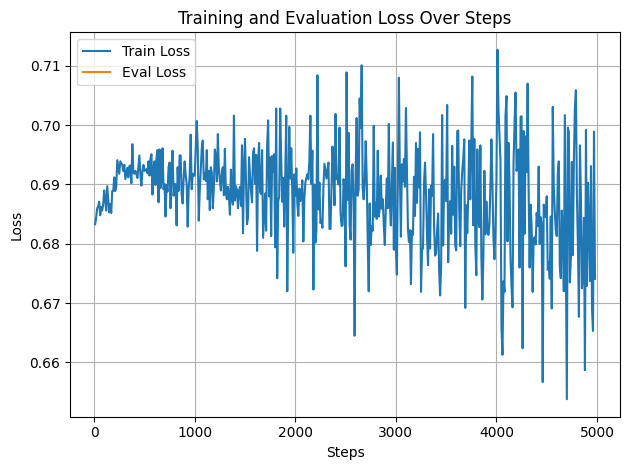

In [79]:
import matplotlib.pyplot as plt

# Initialize lists to hold training and evaluation losses and steps
train_losses = []
eval_losses = []
train_steps = []
eval_steps = []

# Populate the lists from the log history
for entry in trainer.state.log_history:
    if 'loss' in entry:
        train_losses.append(entry['loss'])
        train_steps.append(entry['step'])
    if 'eval_loss' in entry:
        eval_losses.append(entry['eval_loss'])
        eval_steps.append(entry['step'])

# Plot the losses
plt.plot(train_steps, train_losses, label='Train Loss')
plt.plot(eval_steps, eval_losses, label='Eval Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss Over Steps')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [80]:
print("Eval steps:", eval_steps)
print("Eval losses:", eval_losses)


Eval steps: []
Eval losses: []
